# PREDICTING STOCK PRICES USING LSTM 

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
prices = pd.read_csv("/Users/apple/Desktop/projects/prices.csv", encoding = "ISO-8859-1")
from sklearn import metrics
from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout

import warnings
warnings.filterwarnings('ignore')

- Created a sub dataframe for walmart
- Setting date as index 

In [64]:
walmart_stock = pd.DataFrame(prices[prices['symbol'] == 'WMT'])
walmart_stock['date'] = pd.to_datetime(walmart_stock['date'])
walmart_stock.index = walmart_stock['date']
walmart_stock.head()

,date,symbol,open,close,low,high,volume
date,,,,,,,
2010-01-04,2010-01-04,WMT,53.740002,54.230000,53.669998,54.669998,20753100.0
2010-01-05,2010-01-05,WMT,54.090000,53.689999,53.570000,54.189999,15648400.0
2010-01-06,2010-01-06,WMT,53.500000,53.570000,53.419998,53.830002,12517200.0
2010-01-07,2010-01-07,WMT,53.720001,53.599998,53.259998,53.750000,10662700.0
2010-01-08,2010-01-08,WMT,53.430000,53.330002,53.020000,53.529999,11363200.0


 ## Data Exploration 

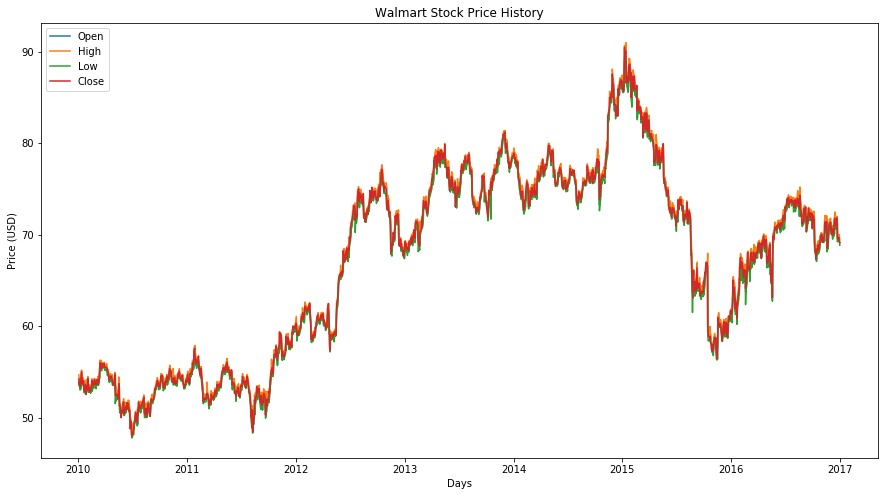

In [65]:
from matplotlib import pyplot as plt
plt.figure(figsize=(15,8))
plt.plot(walmart_stock["open"])
plt.plot(walmart_stock["high"])
plt.plot(walmart_stock["low"])
plt.plot(walmart_stock["close"])
plt.title('Walmart Stock Price History')
plt.ylabel('Price (USD)')
plt.xlabel('Days')
plt.legend(['Open','High','Low','Close'], loc='upper left')
plt.show()

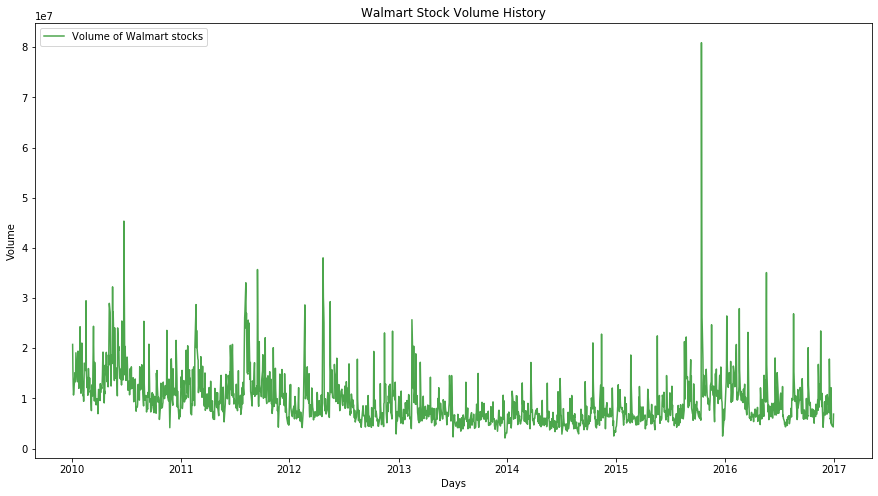

In [66]:
plt.figure(figsize=(15,8))
plt.plot(walmart_stock["volume"],color='green',alpha = 0.7)
plt.title('Walmart Stock Volume History')
plt.ylabel('Volume')
plt.xlabel('Days')
plt.legend(['Volume of Walmart stocks'], loc='upper left')
plt.show()

#### Conclusions 
- Opening, closing, high, low stock value is almost in par with each other, but there are occasional drops in lowest price.
- Walmart stock volume showed few spikes, infact the highest spike in 2015 resulted in walmarts biggetest deline in stock price since 2000, after company said its full-year sales would be flat.


## Data Preparation 

- Creating a new dataframe with only date and closing stock price

In [67]:
data = walmart_stock.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(walmart_stock)),columns=['date', 'close'])
for i in range(0,len(data)):
    new_data['date'][i] = data['date'][i]
    new_data['close'][i] = data['close'][i]

#setting index
new_data.index = new_data.date
new_data.drop('date', axis=1, inplace=True)

- creating test and train datasets
- Scaling closing price

In [68]:
dataset = new_data.values

train = dataset[0:1400,:]
valid = dataset[1400:,:]

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

- I would be predicting a particular day's stock price based on 60 days behind it.
- I am creating two array lists, one to store previous 60 days closing stock prices and other one to store the 61st day's closing stock value 

In [69]:
x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

- I created an LSTM model with 50 neurons and with 3 layers 
- I used mean squared error as loss function and to reduce the loss, I used the adam optimizer.
- I fit the model with a 5 batch size and 20 epochs.

In [70]:
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
#model.add(Dropout(0.2))

model.add(LSTM(units=100, return_sequences=True))
#model.add(Dropout(0.2))

model.add(LSTM(units=100))
#model.add(Dropout(0.2))

model.add(Dense(units = 1))
#model.add(Dropout(0.2))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

model.fit(x_train, y_train, epochs=20, batch_size=5, verbose=2)

Epoch 1/20
 - 11s - loss: 0.0054
Epoch 2/20
 - 11s - loss: 0.0016
Epoch 3/20
 - 11s - loss: 0.0011
Epoch 4/20
 - 11s - loss: 0.0010
Epoch 5/20
 - 11s - loss: 8.2649e-04
Epoch 6/20
 - 11s - loss: 7.0327e-04
Epoch 7/20
 - 11s - loss: 7.2851e-04
Epoch 8/20
 - 11s - loss: 6.8799e-04
Epoch 9/20
 - 11s - loss: 4.7044e-04
Epoch 10/20
 - 11s - loss: 3.9162e-04
Epoch 11/20
 - 11s - loss: 3.7575e-04
Epoch 12/20
 - 11s - loss: 4.5282e-04
Epoch 13/20
 - 11s - loss: 5.3326e-04
Epoch 14/20
 - 10s - loss: 3.9290e-04
Epoch 15/20
 - 11s - loss: 3.5170e-04
Epoch 16/20
 - 11s - loss: 3.8640e-04
Epoch 17/20
 - 10s - loss: 3.3811e-04
Epoch 18/20
 - 10s - loss: 5.1904e-04
Epoch 19/20
 - 10s - loss: 3.6368e-04
Epoch 20/20
 - 10s - loss: 3.1841e-04


In [71]:
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

In [72]:
X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

In [73]:
rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
rms

0.8972039978245049

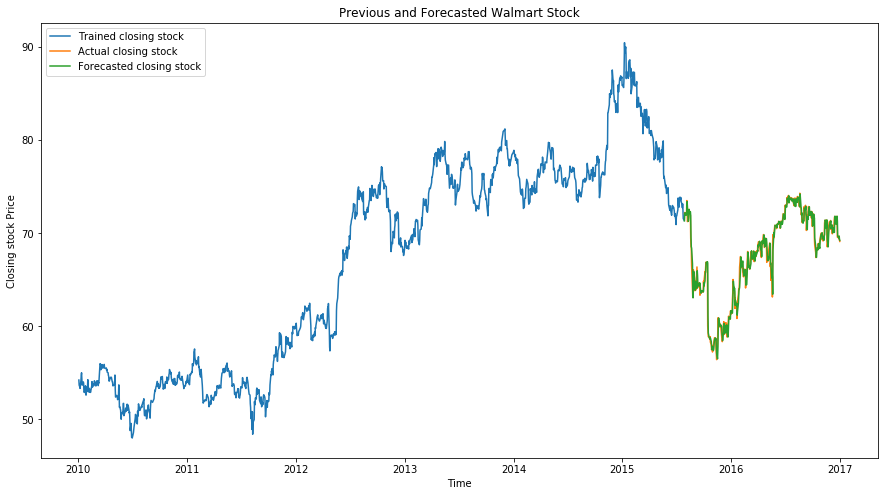

In [74]:
train = new_data[:1400]
valid = new_data[1400:]
valid['Predictions'] = closing_price
plt.figure(figsize=(15,8))
plt.title('Previous and Forecasted Walmart Stock')
plt.plot(train['close'])
plt.plot(valid[['close','Predictions']])
plt.xlabel('Time')
plt.ylabel('Closing stock Price')
plt.legend(['Trained closing stock','Actual closing stock','Forecasted closing stock'], loc='upper left')
plt.show()

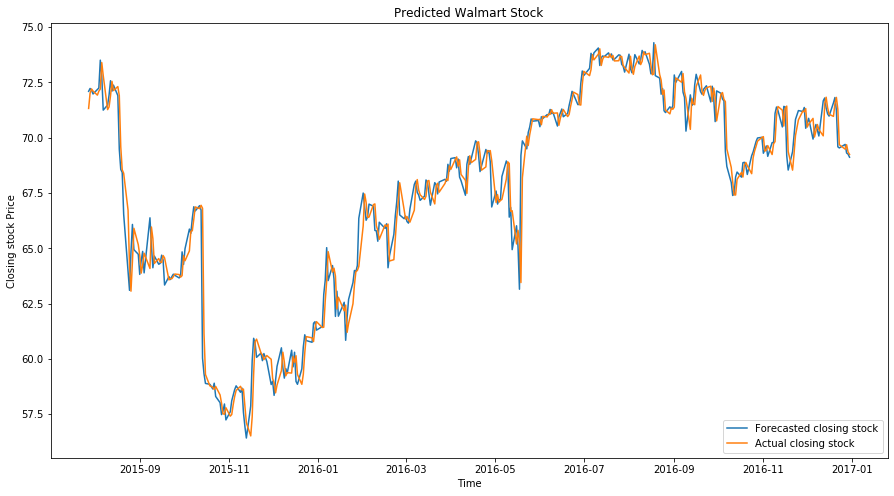

In [75]:
plt.figure(figsize=(15,8))
plt.title('Predicted Walmart Stock')
plt.plot(valid[['close','Predictions']])
plt.xlabel('Time')
plt.ylabel('Closing stock Price')
plt.legend(['Forecasted closing stock','Actual closing stock'], loc='lower right')
plt.show()